In [110]:
from utils import *
import torch
import dgl
from evaluation.evaluator import Evaluator
import pickle
import networkx as nx
from tqdm import tqdm
from torch_geometric.datasets import TUDataset, QM7b, QM9, ZINC
from torch_geometric.utils import to_networkx
from pprint import pprint
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [143]:
def read_dataset(dataset):
    with open(f"data/{dataset}_sampled.pkl", "rb") as f:
        adj_list = pickle.load(f)
    generated = []
    for adj in tqdm(adj_list):
        G = nx.from_numpy_matrix(np.array(adj), create_using=nx.DiGraph)
        Gcc = sorted(nx.strongly_connected_components(G), key=len, reverse=True)
        G0 = G.subgraph(Gcc[0])
        generated.append(G0)
    if dataset == "mutag":
        origin_dataset = TUDataset(name = 'MUTAG', root = './data')
    elif dataset == "QM7b":
        origin_dataset = QM7b(root = './data')
    elif dataset == "QM9":
        origin_dataset = QM9(root = './data')
    elif dataset == "ZINC":
        origin_dataset = ZINC(root='./data')
    elif dataset in ["community", "ego", "er"]:
        with open(f"data/{dataset}_origin.pkl", "rb") as f:
            origin_dataset = pickle.load(f)
    if dataset in ["mutag", "QM7b", "QM9", "ZINC"]:
        original = []
        for graph in origin_dataset:
            original.append(to_networkx(graph))
    elif dataset in ["community", "ego", "er"]:
        original = origin_dataset
    #min_length = min(1000, min(len(generated), len(original)))
    sample=False
    if sampled == True:
        sample_origin = random.sample(original, k = 10)
        sample_generated = random.sample(generated, k = 10)
        generated_dgl = [dgl.DGLGraph(g).to(device) for g in sample_origin] # Convert graphs to DGL from NetworkX
        original_dgl = [dgl.DGLGraph(g).to(device) for g in sample_generated] # Convert graphs to DGL from NetworkX
    else:
        generated_dgl = [dgl.DGLGraph(g).to(device) for g in original] # Convert graphs to DGL from NetworkX
        original_dgl = [dgl.DGLGraph(g).to(device) for g in generated] # Convert graphs to DGL from NetworkX
    return original, generated, original_dgl, generated_dgl

In [149]:
def get_biggest_components(adj_list):
    generated = []
    for adj in tqdm(adj_list):
        G = nx.from_numpy_matrix(np.array(adj), create_using=nx.DiGraph)
        Gcc = sorted(nx.strongly_connected_components(G), key=len, reverse=True)
        G0 = G.subgraph(Gcc[0])
        generated.append(G0)
    return generated

In [182]:
def read_original(dataset):
    original = []
    if dataset == "mutag" or dataset == "mutag2":
        origin_dataset = TUDataset(name = 'MUTAG', root = './data')
    elif dataset == "QM7b":
        origin_dataset = QM7b(root = './data')
    elif dataset == "QM9":
        origin_dataset = QM9(root = './data')
    elif dataset == "ZINC":
        origin_dataset = ZINC(root='./data')
    elif dataset in ["SynCommunity1000", "SynEgo1000", "SynER"]:
        with open(f"data/{dataset}_origin.pkl", "rb") as f:
            origin_dataset = pickle.load(f)
    if dataset in ["mutag", "QM7b", "QM9", "ZINC", "mutag2"]:
        original = []
        for graph in origin_dataset:
            original.append(to_networkx(graph))
    elif dataset in ["SynCommunity1000", "SynEgo1000", "SynER"]:
        original = origin_dataset
    if len(original) > 1000:
        original = original[:1000]
    return original

In [185]:
def read_result(dataset):
    original_dataset = read_original(dataset)
    with open(f"data/{dataset}/{dataset}_ddim_500_sampled.pkl", "rb") as f:
        ddim_500 = pickle.load(f)
        ddim_500 = get_biggest_components(ddim_500)
    with open(f"data/{dataset}/{dataset}_ddim_800_sampled.pkl", "rb") as f:
        ddim_800 = pickle.load(f)
        ddim_800 = get_biggest_components(ddim_800)
    with open(f"data/{dataset}/{dataset}_ddpm_1000_sampled.pkl", "rb") as f:
        ddpm_1000 = pickle.load(f)
        ddpm_1000 = get_biggest_components(ddpm_1000)
    print(len(original_dataset), len(ddim_500), len(ddim_800), len(ddpm_1000))
    ddim_500_dgl = [dgl.DGLGraph(g).to(device) for g in ddim_500] 
    ddim_800_dgl = [dgl.DGLGraph(g).to(device) for g in ddim_800] 
    ddpm_1000_dgl = [dgl.DGLGraph(g).to(device) for g in ddpm_1000]
    original_dgl = [dgl.DGLGraph(g).to(device) for g in original_dataset]

    return [ddim_500_dgl, ddim_800_dgl, ddpm_1000_dgl, original_dgl]

In [200]:
datasets = ["SynCommunity1000", "SynEgo1000", "SynER","QM9", "QM7b", "ZINC"]
result = []
for dataset in datasets:
    result.append(read_result(dataset))

100%|█████████████████████████████████████████████████████████████████████████████| 960/960 [00:00<00:00, 14787.66it/s]
c:\users\deukryeol\appdata\local\programs\python\python37\lib\site-packages\dgl\heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


1000 960 960 960


100%|██████████████████████████████████████████████████████████████████████████████| 960/960 [00:00<00:00, 8475.82it/s]


1000 960 960 960


100%|██████████████████████████████████████████████████████████████████████████████| 960/960 [00:00<00:00, 3124.90it/s]


1000 960 960 960


Extracting data\raw\qm9_v3.zip
100%|██████████████████████████████████████████████████████████████████████████████| 960/960 [00:00<00:00, 6777.35it/s]


1000 960 960 960


100%|██████████████████████████████████████████████████████████████████████████████| 960/960 [00:00<00:00, 2129.58it/s]


1000 960 960 960


100%|██████████████████████████████████████████████████████████████████████████████| 960/960 [00:00<00:00, 2814.53it/s]


1000 960 960 960


In [206]:
heatmap_mmd = np.array([[0] * len(result)] * len(result), dtype=float)
heatmap_fid = np.array([[0] * len(result)] * len(result), dtype=int)

for i, result1 in enumerate(result):
    for j, result2 in enumerate(result):
        eval_result = evaluator.evaluate_all(generated_dataset = result2[0], reference_dataset = result1[3])
        mmd = eval_result['mmd_rbf']
        fid = eval_result['fid']
        heatmap_mmd[i,j] = mmd
        heatmap_fid[i,j] = fid
print(heatmap_mmd)
print("")
print(heatmap_fid)

fid calculation produces singular product; adding 1e-06 to diagonal of cov estimates
fid calculation produces singular product; adding 1e-06 to diagonal of cov estimates
fid calculation produces singular product; adding 1e-06 to diagonal of cov estimates
fid calculation produces singular product; adding 1e-06 to diagonal of cov estimates
fid calculation produces singular product; adding 1e-06 to diagonal of cov estimates
fid calculation produces singular product; adding 1e-06 to diagonal of cov estimates
fid calculation produces singular product; adding 1e-06 to diagonal of cov estimates
fid calculation produces singular product; adding 1e-06 to diagonal of cov estimates
fid calculation produces singular product; adding 1e-06 to diagonal of cov estimates
fid calculation produces singular product; adding 1e-06 to diagonal of cov estimates
[[0.833226   0.59283437 1.80600592 0.75215024 1.99642881 0.86292463]
 [0.93704051 0.79310009 1.66027908 0.6218106  1.99140175 0.31654298]
 [0.85328148

In [197]:
print(datasets)
print(heatmap)

['SynCommunity1000', 'SynEgo1000', 'SynER', 'mutag', 'QM9', 'QM7b']
[[      41       28    70801     1890      428  5325510]
 [      88       69     3774       31        8   594171]
 [      52       39        2       21       29     1126]
 [     353      270   125564     1497      325 10831175]
 [     339      219    65964     1370      156  5018118]
 [     119      118       83      106      112        3]]


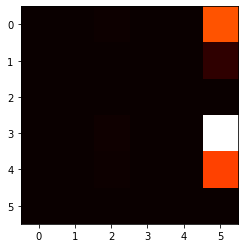

In [198]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(heatmap, cmap='hot')
plt.show()

In [199]:
evaluator = Evaluator(device=device)
def eval_(dataset):
    i500, i800, p1000, g = read_result(dataset)
    eval1 = evaluator.evaluate_all(generated_dataset=i500, reference_dataset=g) 
    eval2 = evaluator.evaluate_all(generated_dataset=i800, reference_dataset=g) 
    eval3 = evaluator.evaluate_all(generated_dataset=p1000, reference_dataset=g) 
    
    print("*********************************")
    print(f"Dataset : {dataset}")
    print("DDIM 500 Result")
    pprint(eval1)
    print("")
    print("DDIM 800 Result")
    pprint(eval2)
    print("")
    print("DDPM 1000 Result")
    pprint(eval3)
    print("")
datasets = ["ZINC"]

for dataset in datasets:
    eval_(dataset)

orthogonal


Extracting data\molecules.zip
Processing...
Processing test dataset: 100%|██████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 16350.41it/s]
Done!
100%|██████████████████████████████████████████████████████████████████████████████| 960/960 [00:00<00:00, 2916.64it/s]
c:\users\deukryeol\appdata\local\programs\python\python37\lib\site-packages\dgl\heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


1000 960 960 960
*********************************
Dataset : ZINC
DDIM 500 Result
{'activations_time': 0.45908665657043457,
 'coverage': 0.0,
 'coverage_time': 0.7019360065460205,
 'density': 0.0,
 'density_time': 0.7019360065460205,
 'f1_dc': 1e-05,
 'f1_dc_time': 0.7019360065460205,
 'f1_pr': 1e-05,
 'f1_pr_time': 0.8677167892456055,
 'fid': 46153.50098832186,
 'fid_time': 0.46803927421569824,
 'mmd_linear': 6708.1904,
 'mmd_linear_time': 0.45908665657043457,
 'mmd_rbf': 0.4346354603767395,
 'mmd_rbf_time': 0.9890601634979248,
 'precision': 0.0,
 'precision_time': 0.8677167892456055,
 'recall': 0.0,
 'recall_time': 0.8677167892456055}

DDIM 800 Result
{'activations_time': 0.2852919101715088,
 'coverage': 0.0,
 'coverage_time': 0.5161573886871338,
 'density': 0.0,
 'density_time': 0.5161573886871338,
 'f1_dc': 1e-05,
 'f1_dc_time': 0.5161573886871338,
 'f1_pr': 1e-05,
 'f1_pr_time': 0.6617240905761719,
 'fid': 48887.86656726349,
 'fid_time': 0.2942688465118408,
 'mmd_linear': 6639.076

In [ ]:
datasets = ["community", "ego", "er", "mutag", "mutag2", "QM9", "QM7b"]

for dataset in datasets:

In [145]:
#origin, generated, origin_dgl, generated_dgl = read_dataset("mutag")

In [146]:
#k = 10
#pos = nx.spring_layout(origin[k])
#nx.draw_networkx(origin[k], pos)

In [147]:
#pos = nx.spring_layout(generated[k])
#nx.draw_networkx(generated[k], pos)

In [148]:
datasets = ["community", "ego", "er"]
import random
for dataset in datasets:
    origin, generated, origin_dgl, generated_dgl = read_dataset(dataset)
    print(dataset)
    eval_(origin_dgl, generated_dgl)

100%|█████████████████████████████████████████████████████████████████████████████| 960/960 [00:00<00:00, 16303.60it/s]
c:\users\deukryeol\appdata\local\programs\python\python37\lib\site-packages\dgl\heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


community
orthogonal
{'activations_time': 0.45547032356262207,
 'coverage': 0.005208333333333333,
 'coverage_time': 0.6989173889160156,
 'density': 0.0024000000000000002,
 'density_time': 0.6989173889160156,
 'f1_dc': 0.0032972296263928343,
 'f1_dc_time': 0.6989173889160156,
 'f1_pr': 0.006987008824895495,
 'f1_pr_time': 0.8153517246246338,
 'fid': 24315.786768837632,
 'fid_time': 0.46442198753356934,
 'mmd_linear': 15382.181,
 'mmd_linear_time': 0.45547032356262207,
 'mmd_rbf': 1.0491768568754196,
 'mmd_rbf_time': 1.0433690547943115,
 'precision': 0.006,
 'precision_time': 0.8153517246246338,
 'recall': 0.008333333333333333,
 'recall_time': 0.8153517246246338}


100%|██████████████████████████████████████████████████████████████████████████████| 960/960 [00:00<00:00, 8021.46it/s]
c:\users\deukryeol\appdata\local\programs\python\python37\lib\site-packages\dgl\heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


ego
orthogonal
fid calculation produces singular product; adding 1e-06 to diagonal of cov estimates
{'activations_time': 0.306180477142334,
 'coverage': 0.013541666666666667,
 'coverage_time': 0.5615682601928711,
 'density': 0.15243902439024393,
 'density_time': 0.5615682601928711,
 'f1_dc': 0.02489072002100099,
 'f1_dc_time': 0.5615682601928711,
 'f1_pr': 0.15407454717486369,
 'f1_pr_time': 0.6589131355285645,
 'fid': 5771.434543238462,
 'fid_time': 0.3189389705657959,
 'mmd_linear': 1815.9868,
 'mmd_linear_time': 0.306180477142334,
 'mmd_rbf': 0.787305636331439,
 'mmd_rbf_time': 0.7449591159820557,
 'precision': 0.3353658536585366,
 'precision_time': 0.6589131355285645,
 'recall': 0.1,
 'recall_time': 0.6589131355285645}


100%|██████████████████████████████████████████████████████████████████████████████| 960/960 [00:00<00:00, 3166.33it/s]
c:\users\deukryeol\appdata\local\programs\python\python37\lib\site-packages\dgl\heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


er
orthogonal
{'activations_time': 0.23337626457214355,
 'coverage': 0.011458333333333333,
 'coverage_time': 0.4594249725341797,
 'density': 0.09473684210526316,
 'density_time': 0.4594249725341797,
 'f1_dc': 0.020460134120326743,
 'f1_dc_time': 0.4594249725341797,
 'f1_pr': 0.2318826344066076,
 'f1_pr_time': 0.5854203701019287,
 'fid': 1541.19797410613,
 'fid_time': 0.24135494232177734,
 'mmd_linear': 277.04047,
 'mmd_linear_time': 0.23337626457214355,
 'mmd_rbf': 0.8561420366168022,
 'mmd_rbf_time': 0.6392085552215576,
 'precision': 0.13157894736842105,
 'precision_time': 0.5854203701019287,
 'recall': 0.975,
 'recall_time': 0.5854203701019287}
